In [1]:
## elotte a df.csv-ben a manual-t lecsereltem w_manual-ra, hogy az abc-ben a manual a vegere keruljon, Igy jon 
#ki jol a pairwise wilcox tablazat szepen. Egyebkent a manualt betenne a tabla kozepere.

#melyik csv-t olvassuk fel? 
#1.)    _bw__df.csv                                             = nincs semmi preproc
#2.)    cut__bw__df.csv                                         = alul/felul egy-egy szelet eldobva
#3./4.) bw_filtered__bw_0.2_df.csv, bw_filtered__bw_0.31_df.csv = 0.2/0.31-es binwidth-del, errosion + dialtion morfologia
#5./6.) bw_cut__bw_0.2_df.csv, bw_cut__bw_0.31_df.csv,          = 0.2/0.31-es binwidth-del, alul/felul egy-egy szelet eldobva
#7.)    filtered__bw__df.csv                                    = errosion/dilation morfologiai operatorok hasznalva

prefix="queried_CSVs/"
#prefix="queried_CSVs/cut_"
#prefix="queried_CSVs/bw_cut_"  #*
#prefix="queried_CSVs/filtered_"
#prefix="queried_CSVs/bw_filtered_"
bw=''                  #ha nincs bw, akkor ezt be kell allitani ures stringre, mert az R megjegyzi a korabbi bw erteket
#bw=0.2                 #ha a prefix bw-vel kezdodik, akkor a rekordok szama 2x annyi, mert van bin_width=0.2 es =0.31-gyel szamolt sor is
#bw=0.31  #*

show_heatmap_of_pvalues                         = TRUE
show_corrplot_of_pvalues                        = TRUE
show_ggboxplot_of_pvalues                       = TRUE
show_corrplot_of_pairwise_wilcox_of_pvalues     = TRUE
calc_fisherM_of_pvalues                         = TRUE
calc2_fisherM_of_pvalues                        = TRUE
calc_super_fisherM_of_pvalues                   = FALSE
calc_sum_of_fisherM_of_pvalues                  = FALSE
calc_distrib_of_volumes                         = TRUE
scaling_with_minMaxMethod                       = TRUE

df=read.csv(paste0(prefix,"_bw_",bw,"_df.csv"))         #cut__bw__df.csv
#df=read.csv("df_nem_lyukas.2022.12.17.csv")

source("015_funcs.r")

Loading required package: gplots


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess


Loading required package: RColorBrewer

corrplot 0.92 loaded



In [2]:
cat(prefix,"_bw_",bw,"_df.csv")
length(df$study_id)/13

queried_CSVs/ _bw_  _df.csv

[1] 43

In [3]:
## db tisztitas
#ha az adott study_id alg-okon belul valamelyik alg nincs meg, akkor beszurok egy uj rekordot es feltoltom NA-kkal

#vegig megyek a study_id-kon
for( i in sort(unique(df$study_id)))
{
    #ha hianyzik valamelyik segmentacios alg, akkor hozzafuzom a df-hez NA-kkal feltoltve
    for(j in c('UT','MAJ_6_6','MAJ_6_5','MAJ_6_4','MAJ_6_3','RW','RG','AC','KM','GMM','FCM','nnunet531','w_manual'))
    { 
        if( ! j %in% df[which(df$study_id == i),3] )  #j benne van-e az adott study_id-hez tartozo segm alg-ok kozott?
        {
            print(paste0(i,",",j))
            tmp=df[which(df$study_id==i),][1,]  #kiszedem az elso rekordot a hianyos study_id-vel rendelkezok kozul, altalaban ez a w_manual
            tmp[3]=j                            #bealliton a hianyzo alg-ra
            tmp[4:length(tmp)]=NA               #minden mas erteket NA-ra allitok
            df=rbind(df,tmp)                    #hozzafuzom az eredeti df-hez
        }
    }
}


#jelentos: 
# bw_filtered_
# bw=0.2 -nel

[1]   5024 380544

[1] 50930.38

[1] 33432

[1] 10.41727

[1] "firstorder_volume"

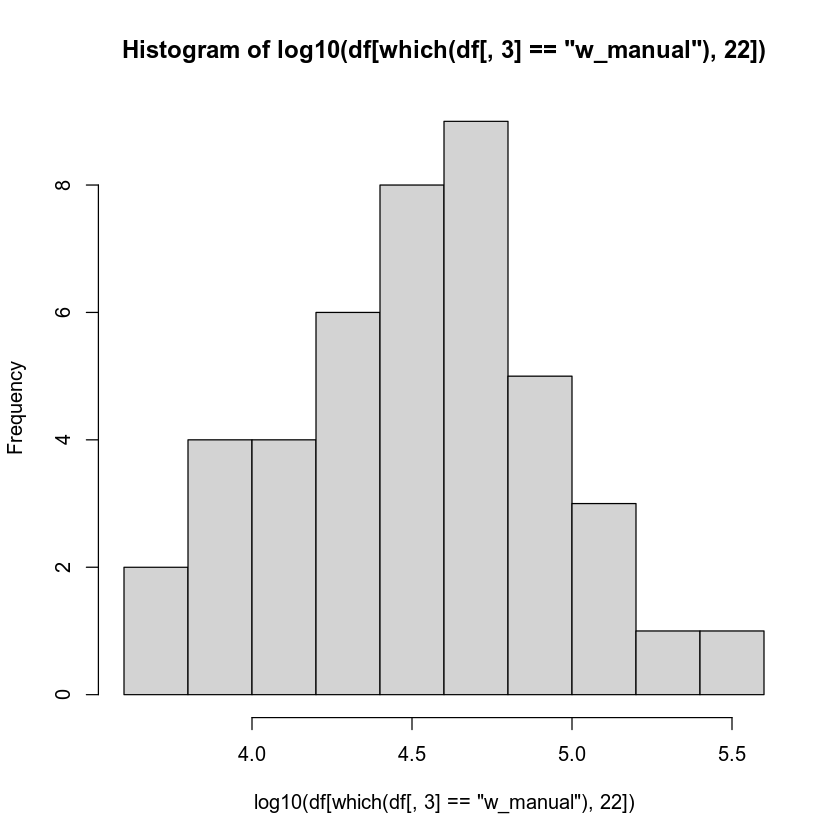

In [4]:
#a csak manualis modszer ertekei = 10ml = 10ccm alatt nem szegmentaltak a dokik, megis volt 5ml-es is.
#a volume mm^3 -ben van merve, atlag 21000mm^3 =  21ccm = 21ml
library(corrplot)
range(df[which(df[,3]=='w_manual'),22])
mean(df[which(df[,3]=='w_manual'),22])
median(df[which(df[,3]=='w_manual'),22])
log(median(df[which(df[,3]=='w_manual'),22]))
colnames(df)[22]

hist(log10(df[which(df[,3]=='w_manual'),22]))


In [5]:
#################################################
#ez egyszerubb az elozore
#manualis es egyes alg-ok terfogatainak eloszlasa
if(calc_distrib_of_volumes==T)
{
    #ezt valamiert nem irja ki
    range(df[,22])
    mean(df[,22])
    median(df[,22])
    
    library("ggplot2")
   
    tmp=data.frame(log10(df[,22]), df[,3]) # a volume mm^3 -ben van merve, atlag 21000mm^3 =  21ccm = 21ml
    colnames(tmp)=c("log10_of_tumour_volume","segmentation_method")
    #X11()
    #p=ggplot(data = tmp) + ggtitle("log10 of manual and segm algs volumes") + 
    p=ggplot(data = tmp) + 
    geom_histogram(aes(x = log10_of_tumour_volume), colour = "black", fill = "white") + 
    labs( x = "tumour volume (log_10 scale)", y = "count")+
    theme(axis.text = element_text( color="#000000", size=16, angle=0),strip.text = element_text(size=20),axis.title=element_text(size = 20))+           #facet szovegmeret
    facet_wrap(~ segmentation_method)
    
    dn=paste0("./figurak/",prefix,"_bw_",bw,"_volumes_segmented_by_algorithms/")
    dir.create(dn)
    fn=paste0("volume_distribution_","_")   # excluded = ki van zarva egy par first order parameter
    
    print(paste("Current working dir: ", getwd()))
    print(paste0("dir/fn: ",dn,fn))

    png(file=paste0(dn,fn,".png"),width=1000,height=1000)
    print(p)
    dev.off()
    
    cairo_ps(file=paste0(dn,fn,".eps")) #,width=1000,height=1000
    print(p)
    dev.off()
    
}

#3D
#x=seq(1,11)
#y=seq(1,7)
#z=-log10(t(fm))
#persp(x,y,z,main="title", zlab = "-log Fisher parameter",theta = 30, phi = 30,col = rainbow(max(z)+1,alpha=1)[z[-1,-1]+1], shade = 0.4,border = NA, box = TRUE)

Warning message in dir.create(dn):
“'./figurak/queried_CSVs/_bw__volumes_segmented_by_algorithms' already exists”


[1] "Current working dir:  /mnt/raid6_dmis0/proj/petlesion/compare_autom-man"
[1] "dir/fn: ./figurak/queried_CSVs/_bw__volumes_segmented_by_algorithms/volume_distribution__"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 10 rows containing non-finite values (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 10 rows containing non-finite values (`stat_bin()`).”


png 
  2

In [6]:
#A first order parameterek kozul melyik fog legjobban vagy legkevesbe korrelalni a manualis modszerrel

#grafikai setup
options(repr.plot.width=10, repr.plot.height=10,repr.plot.pointsize=20)

#kivalasztom azokat a firstorder paramokat, amiknek nagy a szorasa es elrontja a fisher corrplot-ot =
#= a firstorder nagyon elter a tobbitol
#'w_manual''ut''maj_6_6''maj_6_5''maj_6_4''maj_6_3''rw''rg''ac''km''gmm''fcm'
#ut = union of two  rg & fcm

#radiomicsGroupNames = c("firstorder","glcm","shape","glszm","glrlm","ngtdm","gldm")
indices=grep(paste0("firstorder","_.*"), colnames(df))   #1,2,...,19

#manual_szegmentalas ezzel fogok minden egyebet korrellatatni
man=df[which(df$segmentation_method=="w_manual"),indices] # 43 x 19, 43 patients 19 first order params

#ez annyiszor fut le ahany oszlopa van a bemeneti matrixnak (apply 2. parameter = 2)
corr = function(dat){
    i<<-i+1
    #cor(dat,man[,i],use="everything")                  #d2 csupa <NA>
    #cor(dat,man[,i],use="all.obs")                     #error
    #cor(dat,man[,i],use="complete.obs")                #error
    #cor(dat,man[,i],use="na.or.complete")              #firstorder_10percentile0.137854562661963firstorder_90percentile-0.139263292016382firstorder_energy-0.0075...
    cor(dat,man[,i],use="pairwise.complete.obs")        #firstorder_10percentile0.137854562661963firstorder_90percentile-0.139263292016382firstorder_energy-0.007552431...
}
# If ‘use’ is 
# ‘"everything"’, ‘NA’s will propagate conceptually, i.e., a resulting value will be ‘NA’ whenever one of its contributing observations is ‘NA’.
# ‘"all.obs"’, then the presence of missing observations will produce an error.  
# ‘"complete.obs"’ then missing values are handled by casewise deletion (and if there are no complete cases, that gives an error).
# ‘"na.or.complete"’ is the same unless there are no complete cases, that gives ‘NA’.
# ‘"pairwise.complete.obs"’ then the correlation or covariance between each pair of variables is computed using all complete
#    pairs of observations on those variables.  This can result in covariance or correlation matrices which are not positive
#    semi-definite, as well as ‘NA’ entries if there are no complete pairs for that pair of variables.  For ‘cov’ and ‘var’,
# ‘"pairwise.complete.obs"’ only works with the ‘"pearson"’ method.
# Note that (the equivalent of) ‘var(double(0), use = *)’ gives ‘NA’ for ‘use = "everything"’ and ‘"na.or.complete"’, and gives an error in the other cases.


test = function(aggregated_fun){
    i<<-0;d1<<-apply(man,2,aggregated_fun)  #first order parameterenkent aggregalok
    i<<-0;d2<<-apply(df[which(df$segmentation_method=="UT"),indices],2,aggregated_fun)
    i<<-0;d3<<-apply(df[which(df$segmentation_method=="MAJ_6_6"),indices],2,aggregated_fun)
    i<<-0;d4<<-apply(df[which(df$segmentation_method=="MAJ_6_5"),indices],2,aggregated_fun)
    i<<-0;d5<<-apply(df[which(df$segmentation_method=="MAJ_6_4"),indices],2,aggregated_fun)
    i<<-0;d6<<-apply(df[which(df$segmentation_method=="MAJ_6_3"),indices],2,aggregated_fun)
    i<<-0;d7<<-apply(df[which(df$segmentation_method=="RW"),indices],2,aggregated_fun)
    i<<-0;d8<<-apply(df[which(df$segmentation_method=="RG"),indices],2,aggregated_fun)
    i<<-0;d9<<-apply(df[which(df$segmentation_method=="AC"),indices],2,aggregated_fun)
    i<<-0;da<<-apply(df[which(df$segmentation_method=="KM"),indices],2,aggregated_fun)
    i<<-0;db<<-apply(df[which(df$segmentation_method=="GMM"),indices],2,aggregated_fun)
    i<<-0;dc<<-apply(df[which(df$segmentation_method=="FCM"),indices],2,aggregated_fun)
    i<<-0;dd<<-apply(df[which(df$segmentation_method=="nnunet531"),indices],2,aggregated_fun)
}

#test(var)  #cov = sd^2 = sigma^2_xx
#test(sum)
#test(sd)
#test(mean)
test(corr)

#folyt. kov. cellaban

In [7]:
#elobbi cella folytatasa

n=length(d1)

#pname = param's name
xd1=data.frame(pname=names(d1),val=as.numeric((d1)),meth=rep("manual",n))
xd2=data.frame(pname=names(d2),val=as.numeric((d2)),meth=rep("UT",n))
xd3=data.frame(pname=names(d3),val=as.numeric((d3)),meth=rep("MAJ_6_6",n))
xd4=data.frame(pname=names(d4),val=as.numeric((d4)),meth=rep("MAJ_6_5",n))
xd5=data.frame(pname=names(d5),val=as.numeric((d5)),meth=rep("MAJ_6_4",n))
xd6=data.frame(pname=names(d6),val=as.numeric((d6)),meth=rep("MAJ_6_3",n))
xd7=data.frame(pname=names(d7),val=as.numeric((d7)),meth=rep("RW",n))
xd8=data.frame(pname=names(d8),val=as.numeric((d8)),meth=rep("RG",n))
xd9=data.frame(pname=names(d9),val=as.numeric((d9)),meth=rep("AC",n))
xda=data.frame(pname=names(da),val=as.numeric((da)),meth=rep("KM",n))
xdb=data.frame(pname=names(db),val=as.numeric((db)),meth=rep("GMM",n))
xdc=data.frame(pname=names(dc),val=as.numeric((dc)),meth=rep("FCM",n))
xdd=data.frame(pname=names(dd),val=as.numeric((dd)),meth=rep("nnunet531",n))
xdall=rbind(xd1,xd2,xd3,xd4,xd5,xd6,xd7,xd8,xd9,xda,xdb,xdc,xdd)

library("ggplot2")
#ezek lesznek pirossal szinezve, a tobbi marad fekete ld.: colour = a
a <- ifelse(  xdall$pname == "firstorder_10percentile" | xdall$pname == "firstorder_minimum"  | xdall$pname == "firstorder_median"
            | xdall$pname == "firstorder_volume"       | xdall$pname == "firstorder_kurtosis" | xdall$pname == "firstorder_skewness"
            | xdall$pname == "firstorder_uniformity",  "red", "black")
legends=c("manual","RW","AC","KM","GMM","RG","FCM","UT","MAJ_6_3","MAJ_6_4","MAJ_6_5","MAJ_6_6","nnunet531")
#Az 1 sor missing value azert van, mert az osszes ut a firstorder_minimumra = 0, ennek a manualissal a korrelacioja = NA.
#Standard dev=0 -> correlacio = NA.
#       pname	            val	meth
#30	    firstorder_minimum	NA	ut

#rg es maj_6_6 NA-kat tartalmaz, ezeket a use="complete.obs"-szal utom ki 
p = ggplot(xdall,aes(pname,val,fill=factor(meth,legends))) + geom_col(position = "dodge")
p = p + coord_flip()
p = p + theme(text = element_text(size = 20)) 
p = p + theme(axis.text.y = element_text(angle = 0, hjust = 1, colour = a))
#p = p + labs(y = NULL, x = "parameter", title = "correlation of algorithmic and manual segmentation", fill = "segm.meth")     
p = p + labs(y = NULL, x = "parameter", fill = "segm.meth")     
    
dn=paste0("./figurak/",prefix,"_bw_",bw,"_histogram_of_correlation_of_man_and_algi/")
dir.create(dn)
fn=paste0("correlation_of_algorithmic_and_manual_segmentation","_")
png(file=paste0(dn,fn,".png"),width=1000,height=1000)
p
dev.off()

Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”
Warning message in dir.create(dn):
“'./figurak/queried_CSVs/_bw__histogram_of_correlation_of_man_and_algi' already exists”


png 
  2

In [8]:
#ezeket kihagyom, hogy a first_order parameterek ne legyenek annyira különbözőek (jobbak) a többitől
 df$firstorder_10percentile=NULL
 #df$firstorder_90percentile=NULL
#df$firstorder_energy=NULL
#df$firstorder_entropy=NULL
#df$firstorder_interquartilerange=NULL
 df$firstorder_kurtosis=NULL
 
 df$firstorder_minimum=NULL
 #df$firstorder_maximum=NULL

#df$firstorder_meanabsolutedeviation=NULL
# df$firstorder_mean=NULL
 df$firstorder_median=NULL

 #df$firstorder_range=NULL

#df$firstorder_robustmeanabsolutedeviation=NULL
#df$firstorder_rootmeansquared=NULL
df$firstorder_skewness=NULL
#df$firstorder_totalenergy=NULL

df$firstorder_uniformity=NULL
#df$firstorder_variance=NULL
 df$firstorder_volume=NULL

In [9]:
#In Fisher method only normal distributions can be used
# check the normality of radiomic parameters
print("-------------------------------------------------------------------------------------------------------------------")
print("hold normal distribution, inserting +1, and generate a list of to be eliminated, NOT normal, params, insering -1")
print("-------------------------------------------------------------------------------------------------------------------")
segmMethodNames = as.character(unique(df$segmentation_method))
goodOrnot=data.frame(matrix(-1,ncol(df)-3,length(segmMethodNames)))
colnames(goodOrnot)=segmMethodNames
rownames(goodOrnot)=colnames(df[4:length(df)])
for (s in segmMethodNames){
    for (p in 4:ncol(df)){   #df columns: parameters, lines algorithms, first 3 columns are administrative ones
        #print(p)
        #hist(df[which(df[,3]=='fcm'),which(colnames(df)=='gldm_lowgraylevelemphasis')])
        norm=shapiro.test(df[which(df[,3]==s),p])$p.value
        if(norm>=0.05)
        {
            #print(paste0(p-3,",",colnames(df)[p],": ",norm))
            goodOrnot[p-3,s]=1 #mert az elso harom oszlop: study_instance_uid,study_id,segmentation_method
        }
    }
}
#goodOrnot

[1] "-------------------------------------------------------------------------------------------------------------------"
[1] "hold normal distribution, inserting +1, and generate a list of to be eliminated, NOT normal, params, insering -1"
[1] "-------------------------------------------------------------------------------------------------------------------"


In [10]:
goodOrnot[1:10,]

,AC,FCM,GMM,KM,MAJ_6_3,MAJ_6_4,MAJ_6_5,MAJ_6_6,w_manual,nnunet531,RG,RW,UT
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
firstorder_90percentile,1,1,1,1,1,1,1,1,1,1,1,1,1
firstorder_energy,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
firstorder_entropy,1,-1,1,-1,-1,1,1,1,-1,1,1,1,-1
firstorder_interquartilerange,1,1,-1,1,1,1,-1,-1,1,1,1,-1,1
firstorder_maximum,1,1,1,1,1,1,1,1,1,1,1,1,1
firstorder_meanabsolutedeviation,1,1,-1,1,1,1,1,1,1,1,1,1,1
firstorder_mean,1,1,1,1,1,1,1,1,1,1,-1,1,1
firstorder_range,-1,-1,1,-1,-1,-1,-1,1,1,1,1,-1,1
firstorder_robustmeanabsolutedeviation,1,1,-1,1,1,1,-1,1,1,1,1,-1,1


In [11]:
if(scaling_with_minMaxMethod==TRUE)
{
    #With Min-Max Scaling, we scale the data values between a range of 0 to 1 only. Due to this, 
    #the effect of outliers on the data values suppresses to a certain extent. Moreover, it helps us 
    #have a smaller value of the standard deviation of the data scale.
    #https://www.digitalocean.com/community/tutorials/normalize-data-in-r
    #install.packages("caret")
    library("caret")
    pproc = preProcess(df, method=c("range"))
    df_norm = predict(pproc,df)
    df=df_norm
    print("scaling_with_minMaxMethod")
} else {
    #scaling_with_standardization
    #In Standard scaling, also known as Standardization of values, we scale the data values such that 
    #the overall statistical summary of every variable has a mean value of zero and an unit variance value.
    df_norm = as.data.frame(scale(df[,4:ncol(df)]))
    df[,4:ncol(df)] = df_norm
    print("scaling_with_standardization")
}

Loading required package: lattice



[1] "scaling_with_minMaxMethod"


In [12]:
#study_instance_uid study_id segmentation_method firstorder_10percentile firstorder_90percentile firstorder_energy firstorder_entropy firstorder_interquartilerange firstorder_kurtosis fir
#42174574200751            7            w_manual                  1.6831                  6.4405          32983.67             3.0571                        2.4556              3.7615
#42174574200751            7                 FCM                  3.4361                  7.8697          27040.65             3.0671                        2.3989              2.7356
#42174574200751            7                 GMM                  5.1152                  8.5798          19878.61             3.0282                        2.0694              2.4336
#42174574200751            7                  KM                  3.2653                  7.7676          27681.76             3.0329                        2.4551              2.7885

In [13]:
segmMethodNames = as.character(unique(df$segmentation_method))  #'AC''FCM''GMM''KM''MAJ_6_3''MAJ_6_4''MAJ_6_5''MAJ_6_6''nnunet531''RG''RW''UT' 'w_manual'
segmMethodNames = segmMethodNames[segmMethodNames!="w_manual"]  #kiszedem a manualis modszert
radiomicsGroupNames = c("firstorder","glcm","shape","glszm","glrlm","ngtdm","gldm")
            
#Fisher modszerhez eredmenyeinek tarolasahoz matrix helyfoglalas
fm = matrix(0,nrow=length(radiomicsGroupNames),ncol=length(segmMethodNames)-0) # 7: ennyi radmics csoport van, az oszlopok szamaban azert van -0, mert korabban a manualist manualishoz nem

#######################################################################
#itt gyujtom ossze az osszes radiomics parameterhez tartozo p ertekeket
PVals = data.frame(matrix(0,nrow=length(colnames(df))-3,ncol=length(segmMethodNames))) #-3 azert mert az 4. oszloptol jonnek a rad. params.
colnames(PVals) = segmMethodNames

In [14]:
oldw <- getOption("warn") #regi warning beallitasok lemasolasa
options(warn = -1)        #warnings kikapcs

#########################################################################################
#az itt kovetkezo for ciklusban csak egy rad param group-ba tartozo ertkekkel foglalkozok
#vegig megyek az oszlopokon = radiomics parametreken. Ezek lesznek az eredmeny matrix (pValues) sorai
#for(i in from:length(colnames(df)) )
#vegig megyek az oszlop csoportokon = radiomics parameter csoportokon. Ezek lesznek az eredmeny matrix (pValues) sorai
cntr=0  #to fill the PVals matrix properly
for( radiomicsGroupName in radiomicsGroupNames )
{
    print(paste("radiomicsGroupName: ",radiomicsGroupName))
    radParamsInGroup = grep(paste0(radiomicsGroupName,"_.*"), colnames(df))     #indexeket ad vissza, pl.:  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
    from=radParamsInGroup[1]
    #placeholder radiomics csoportonkent felulirodik
    pValues = matrix(0,nrow=length( radParamsInGroup ),ncol=length(segmMethodNames)) #oszlopok szamaban azert van -1, mert a manualist manualishoz nem hasonlitom
    #adott csoporton belul kiszedek minden parametert
    for(i in radParamsInGroup )
    {
        cat("\ni",i)
        #minden betegtol osszegyujtom a manualis modszerre es az i-vel jelolt aktualis rdiomics parameterre vonatkozo radiomics parametereket
        manualRadParams=df[ which(df[,3]=="w_manual"), i ]              #43 elemu vektor = ahany paciens van, pl.: i = "firstorder_10percentile"
        for(j in 1:length(segmMethodNames))                             #nincs benne a manualis
        {
            #vegig megyek a sorokon, amik egy faktor valtozo (1,2,3,4,5,6,7,8,9,10,{FCM,GMM,KM,stb}), ennek csak a kulonbozo elemeit veszem ki
            segmMethodName = segmMethodNames[j]
            #minden betegtol osszegyujtom az aktualis segm. modszerre es az i-vel jelolt aktualis rdiomics parameterre vonatkozo radiomics parametereket
            segmMethodRadParams = df[ which(df[,3]==segmMethodName), i ]        #szinten 43 elemu vektor, jobb hijan neha csak 38 pl. a "MAJ_6_6"-nal, ott amiatt, hogy az rg 2 esetben nem mukodott maj_6_6 sem keletkezett
            #print(paste0(as.character(i),", manual-", segmMethodName ));
            #es osszehasonlitom a manualis roi-n belul szamolt radiomics parametereket a kulonbozo szegmentacios modszerekkel keszult roikon beluli radiomics parameterekkel
            #test      = pairwise.wilcox.test(df[,i],df$segmentation_method)$p.value[10,]

            # Wilcokoxon test akkor hasznalhato, ha a mintak nem tesznek eleget a normalitas vizsgalatnak
            # Ekkor a student T proba helyett ez jo. Valami olyasmit csinal, hogy atrendezi az adatokat,
            # hozzatesz valamilyen szempont szerint...
            # ket eloszlas tavolsagat hatarozza meg
            test      = wilcox.test(manualRadParams,segmMethodRadParams,exact=FALSE)$p.value

            pvalue   = as.numeric( test );
            #pValues[i-from+1,j-1] = pvalue
            pValues[i-from+1,j] = pvalue        #pValues: soronkent toltom fel, egy sor = egy param. Egy sorban algoritmusonkent toltok fel. Dimenzio = parameterekszama x algoritmusok szama
        }
        cntr = cntr + 1
        PVals[cntr,] = pValues[i-from+1,]               #egy sor egy param, egy oszlop egy alg
        rownames(PVals)[cntr]=colnames(df)[i]           #rad paramsbol szedegetem ki
    }#end of rad params in a specific group

    #ebben csak az aktualis csoporbeli rad. parameterek szerepelnek
    colnames(pValues) = segmMethodNames
    rownames(pValues) = colnames(df[,radParamsInGroup])

    #head(dfres[1:10,1:10])
    #                                       FCM          GMM           KM           AC          RG           RW      MAJ_6_3      MAJ_6_4      MAJ_6_5      MAJ_6_6
    #firstorder_10percentile       1.054852e-11 2.987034e-20 2.770514e-11 1.054852e-11 0.001278102 8.781316e-16 8.948429e-12 1.340985e-13 7.198637e-17 2.137595e-20
    #firstorder_90percentile       2.115973e-01 1.088371e-02 2.380338e-01 1.902470e-01 0.789953864 5.829643e-02 2.084465e-01 1.379511e-01 5.060634e-02 8.909926e-03
    #firstorder_energy             3.181054e-01 3.788517e-03 3.394843e-01 2.936290e-01 0.836625242 1.523351e-01 3.663133e-01 2.593187e-01 1.123179e-01 2.473036e-03

    dfres=data.frame(pValues)                           #sorok: rad.params in rad.param.group, oszlopok: alg-ok

    #false discovery rate: FDR = FP / (FP + TP)
    #oszloponkent (algoritmusonkent) tortenik a false discovery rate kompenzalas, mert kulonbozo alg.-kat akarunk osszehasonlitani
    for(k in 1:(length(segmMethodNames)) ){ p.adjust(dfres[,k],method="fdr") }

    #install.packages("fdrtool")
    #library("fdrtool")
    #for(k in 1:(length(segmMethodNames)-1) ){ fdrtool(dfres[,k], statistic="pvalue") }

    #filter out p-value >= 5%; a kulonbseg nem szignifikans
    #pValues[which(pValues>=0.05)]=0
    #dfres[(which(dfres>=0.05,arr.ind=T))]=0

    cat("\n")
    
    ############################################################################################################
    #hmap_of_minusLogPValues_of_man_and_algi_vs_radPramsInGroup
    if(show_heatmap_of_pvalues==T)
    {
        print("show_heatmap_of_pvalues")
        fun_show_heatmap_of_pvalues(prefix,bw,dfres)
    }

    ############################################################################################################
    #corrplot_of_minusLogPValues_of_man_and_algi_vs_radPramsInGroup
    #hmap_of_minusLogPValues_of_man_and_algi_vs_radPramsInGroup
    if(show_corrplot_of_pvalues==T)
    {
        
#Kivesszuk az UT algoritmust, mert nehezen magyarazhato, hogy miert hasonlit kevesbe a manualis maszkhoz mint azok amikbol szamolva lett (RG+FCM). 
#Valoszinuleg szamolasi hiba van az UT szamolasakor. A ket hasonlosagi parameter (-log fisher-p-value) koze, jobb esetben ala keleltt volna skalazodnia.

        dfres$UT=NULL
        
        print("show_corrplot_of_pvalues")
        fun_show_corrplot_of_pvalues(prefix,bw,dfres)
    }

    if( show_ggboxplot_of_pvalues==T || show_corrplot_of_pairwise_wilcox_of_pvalues==T )
    {
        print("show_ggboxplot_of_pvalues | show_corrplot_of_pairwise_wilcox_of_pvalues")
        #a pValues matrixot atalakitom olyan data.frame-re, hogy elso oszlopban lesznek a p-value ertekek a manualis es algi-bol szamolva, masodik oszlopban az algoritmusok, kvazi faktorvaltozokent
        DF=data.frame(-log(dfres[,1]),colnames(dfres)[1])   #a 2. oszlop egy factor valtozo lesz (dfres oszlopai = alg.-ok)  itt az elso oszlopot (alg-t) vesszuk ki ("AC").
        for(i1 in 2:length(segmMethodNames))                #itt a tobbit
        {
            DF2=data.frame(-log(dfres[,i1]),colnames(dfres)[i1])
            DF=rbind(as.matrix(DF),as.matrix(DF2))
        }
        DATA.FRAME=data.frame(DF)
        #    colnames(DATA.FRAME)=c("-log(p-value with FDR)","algorithm")
        colnames(DATA.FRAME)=c("neg_log_p_val_w_FDR","algorithm")
        DATA.FRAME[,1]=round(as.numeric(as.character(DATA.FRAME[,1])),2)

        ############################################################################################################
        #paronkenti wilcoxon test-et futtat az alg-ok osszehason-ra (a stat sokasagok nem norm. eloszlasuak /ezert wilcox 
        #es nem student-t/), hogy vajon
        #a sokasasgok mean-jei mennyire ternek el egymastol. Ha a p-value < 5%, akkor kulonboznek. Ha tobb sokasagot 
        #hasonlitunk ossze egyszerre, arra kruskal-wallis ad p-value-t
        #rm -rf ~/R/x86_64-pc-linux-gnu-library/3.4/00LOCK-rlang/
        # install.packages("https://cran.r-project.org/src/contrib/rlang_1.0.6.tar.gz",repos=NULL,type="source")
        if(show_ggboxplot_of_pvalues==T)            
        {
            print("   show_ggboxplot_of_pvalues")
            fun_show_ggboxplot_of_pvalues(prefix,bw,DATA.FRAME,segmMethodNames)
        }

        ############################################################################################################
        #heatmap-es abrazolas, megnezem, hogy az egyes alg-okhoz tartozo radiomics params, ha osszefuggo adatokat alkotnanak 
        #(=egy populaciohoz tartoznanak), (abban az ertelemben egyformak, hogy mindegyik p-value), milyen tavol vannak egymastol
        if(show_corrplot_of_pairwise_wilcox_of_pvalues==T)
        {
            print("   show_corrplot_of_pairwise_wilcox_of_pvalues")
            fun_show_corrplot_of_pairwise_wilcox_of_pvalues(prefix,bw,segmMethodNames,DATA.FRAME)
        }

    }
        
    #################################################################################
    #Fisher Modszer, fuggetlen p-value-ek osszekombinalasara rad. param csoportonkent = egy sor megfelel egy csoporton beluli p-value-k osszekombinalasanak
    if(calc_fisherM_of_pvalues==T)
    {
        print("fisher calc")
        library("poolr")
        rowIndex = grep(radiomicsGroupName,radiomicsGroupNames)         # 1...7 (7 rad.para.group letezik)
        
        #korrelacios matrix gyartasa a fisher modszerhez, mert a kulonbozo parameterek nem fuggetlenek egymastol
        r<-cor(t(dfres))
        fm[rowIndex,] = apply(dfres,2,fisherM,r)                          #apply() masodik parametere = 2, mert a dfres oszlopaibol(=alg-ok, osszesen 12db) csinal vektort es arra alkalmazza a fisherM-et. dfres sorai = rad.params in rad.param.group
    }

}#end of radiomicsGroupNames loop

options(warn = oldw)     #warnings visszakapcs

[1] "radiomicsGroupName:  firstorder"

i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
[1] "show_heatmap_of_pvalues"
[1] "show_corrplot_of_pvalues"
[1] "show_ggboxplot_of_pvalues | show_corrplot_of_pairwise_wilcox_of_pvalues"


ERROR: Error in `[.data.frame`(dfres, , i1): undefined columns selected


In [15]:
#itt csak tanulom a wilcoxon tesztet

cat("segmMethodName: ",segmMethodName," from: ",segmMethodNames)
cat("\n",radiomicsGroupName," from ",radiomicsGroupNames)
cat("\n",i," in ",radParamsInGroup)

cat("\n\n")

#wilcox.test(manualRadParams,segmMethodRadParams,exact=FALSE)$p.value
cat("manual &",segmMethodName, ", param: ",radiomicsGroupName,"\n")
str(manualRadParams)
str(segmMethodRadParams)
wilcox.test(manualRadParams,segmMethodRadParams,exact=FALSE)
#wilcox.test(manualRadParams,segmMethodRadParams,exact=FALSE)$p.value


#Mit is jelent a W a wilcox reportban:
#https://library.virginia.edu/data/articles/the-wilcoxon-rank-sum-test
#This is actually the number of times that a manualRadParams is less than a segmMethodRadParams.
W <- 0
for(ii in 1:length(segmMethodRadParams)){
  for(jj in 1:length(manualRadParams)){
    if(isTRUE(segmMethodRadParams[ii] < manualRadParams[jj]))    { W <- W + 1}
  }
}

cat("\nW:",W)

#sum(outer(segmMethodRadParams, manualRadParams, "<"))

segmMethodName:  UT  from:  AC FCM GMM KM MAJ_6_3 MAJ_6_4 MAJ_6_5 MAJ_6_6 nnunet531 RG RW UT
 gldm  from  firstorder glcm shape glszm glrlm ngtdm gldm
 53  in  40 41 42 43 44 45 46 47 48 49 50 51 52 53

manual & UT , param:  gldm 
 num [1:43] 0.1162 0.0541 0.0732 0.0732 0.0796 ...
 num [1:43] 0.258 0.255 0.482 0.282 0.221 ...



	Wilcoxon rank sum test with continuity correction

data:  manualRadParams and segmMethodRadParams
W = 247.5, p-value = 8.488e-09
alternative hypothesis: true location shift is not equal to 0



W: 242

In [16]:
fm

7.315482e-05,7.735161e-04,9.003615e-20,1.598623e-03,7.359690e-04,2.349577e-05,4.287523e-09,1.246364e-20,7.769664e-01,8.003369e-01,1.171901e-07,2.404505e-04
3.416688e-26,3.175336e-25,1.275055e-56,4.707099e-24,2.460267e-25,1.435715e-30,5.703141e-41,2.292487e-56,3.288366e-04,8.333739e-06,5.579092e-35,2.623452e-28
7.425315e-14,9.789559e-12,8.982306e-46,7.184567e-11,3.179968e-12,6.151372e-18,1.562541e-28,1.061556e-48,7.410252e-01,5.246159e-01,5.337639e-21,4.220809e-15
7.496568e-20,6.104773e-33,9.962825e-64,5.693666e-28,1.031400e-31,1.779730e-32,4.646887e-53,7.848215e-63,2.126622e-02,1.566542e-04,1.008708e-45,3.549702e-34
8.192636e-25,1.451893e-21,2.397066e-61,8.947893e-20,9.308146e-22,6.047472e-27,1.922512e-40,1.068235e-61,2.863398e-05,1.630363e-09,6.044897e-40,1.691527e-24
1.990394e-07,4.715607e-07,3.362340e-15,1.168353e-06,3.399861e-07,9.580951e-09,1.756673e-11,4.577250e-16,4.295040e-02,1.709037e-03,3.204539e-09,1.243153e-07
3.904709e-07,1.059815e-07,1.844053e-18,5.628553e-07,9.958345e-08,9.961292e-09,7.171395e-13,6.977317e-19,1.774412e-02,1.892433e-02,3.384134e-11,1.974101e-08


In [17]:
#csoportonkent tartalmaz p ertekekekt pValues -> dfres 
#minden egyben pVals -> dfresAll

#Az utobbit fdr-ezem meg itt

cat("segmMethodName: ",segmMethodName,", from: ",segmMethodNames)
cat("\n\n")

#A radiomicsGroupNames-en gyalogol vegig a legkulso for ciklus, igy a sornevek jok lesznek
rownames(fm) = radiomicsGroupNames
colnames(fm) = segmMethodNames

#####################################################################
#Az osszes rad.param-ra alg-onkent False Discovery Rate-et alkalmazok
dfresAll=data.frame(PVals)                           #sorok: rad.params in rad.param.group, oszlopok: alg-ok

#false discovery rate: FDR = FP / (FP + TP)
#oszloponkent (algoritmusonkent) tortenik a false discovery rate kompenzalas, mert kulonbozo alg.-kat akarunk osszehasonlitani

for(k in 1:(length(segmMethodNames)) ){ p.adjust(dfresAll[,k],method="fdr") }

segmMethodName:  UT , from:  AC FCM GMM KM MAJ_6_3 MAJ_6_4 MAJ_6_5 MAJ_6_6 nnunet531 RG RW UT



segmMethodName:  UT , from:  AC FCM GMM KM MAJ_6_3 MAJ_6_4 MAJ_6_5 MAJ_6_6 nnunet531 RG RW UT



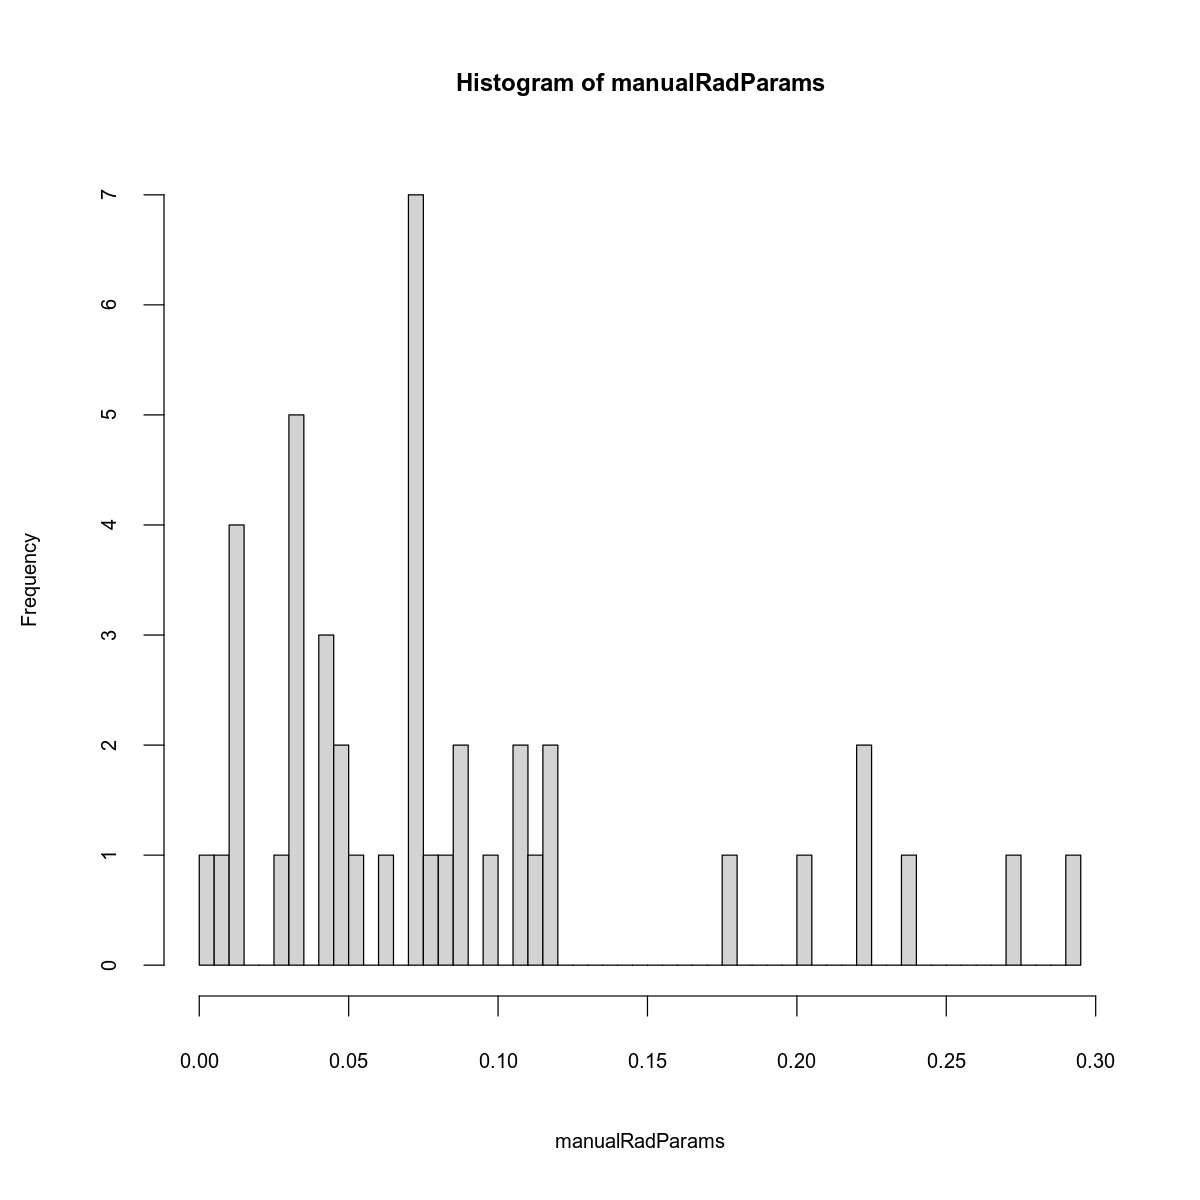

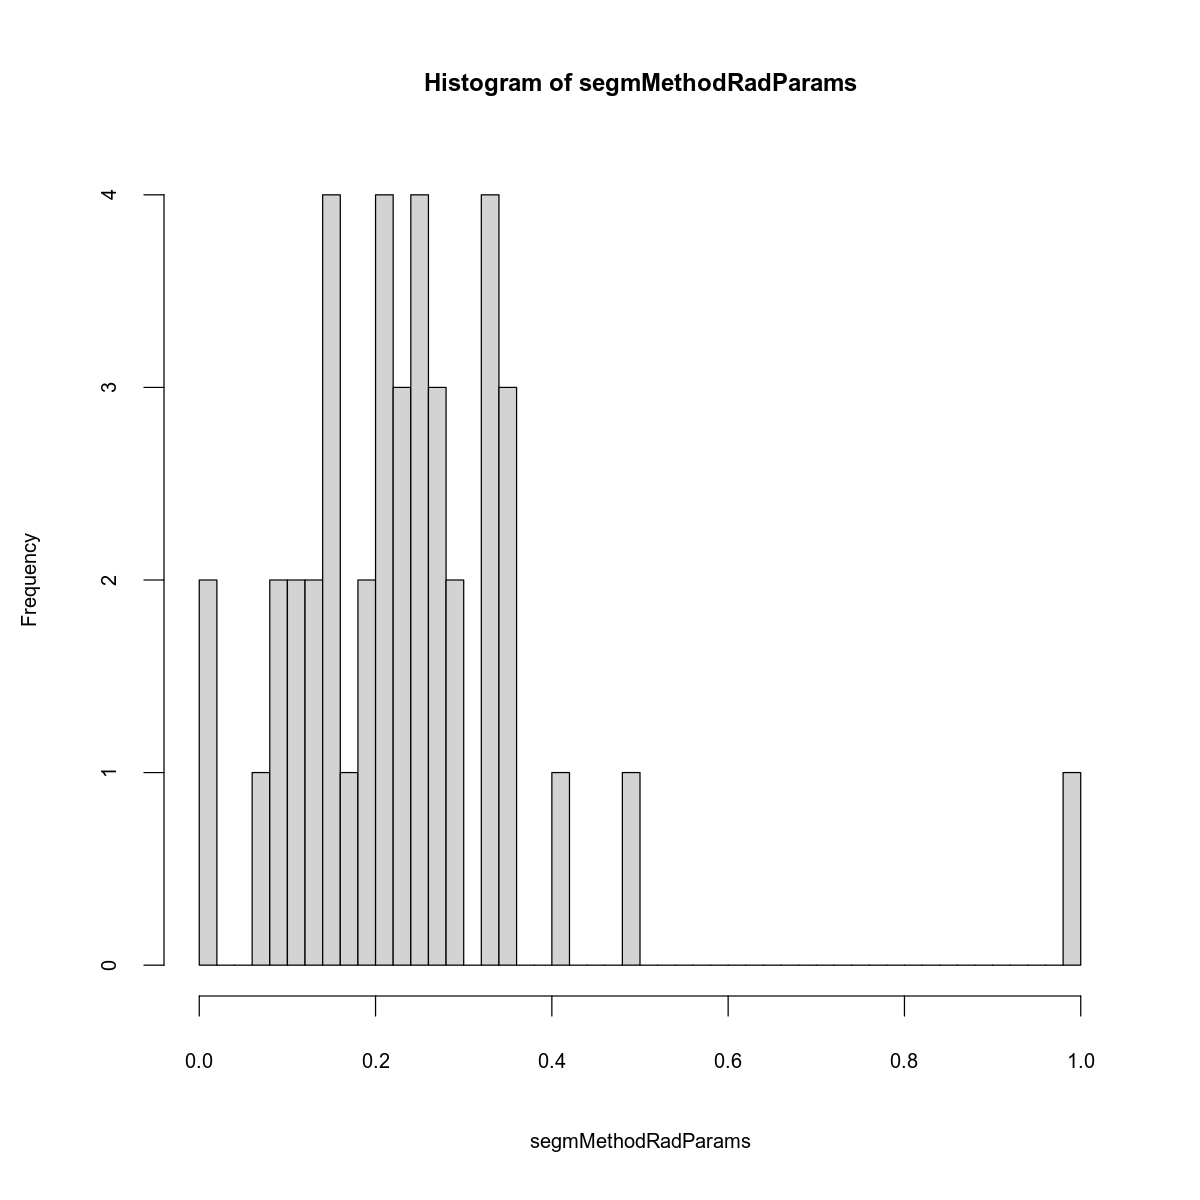

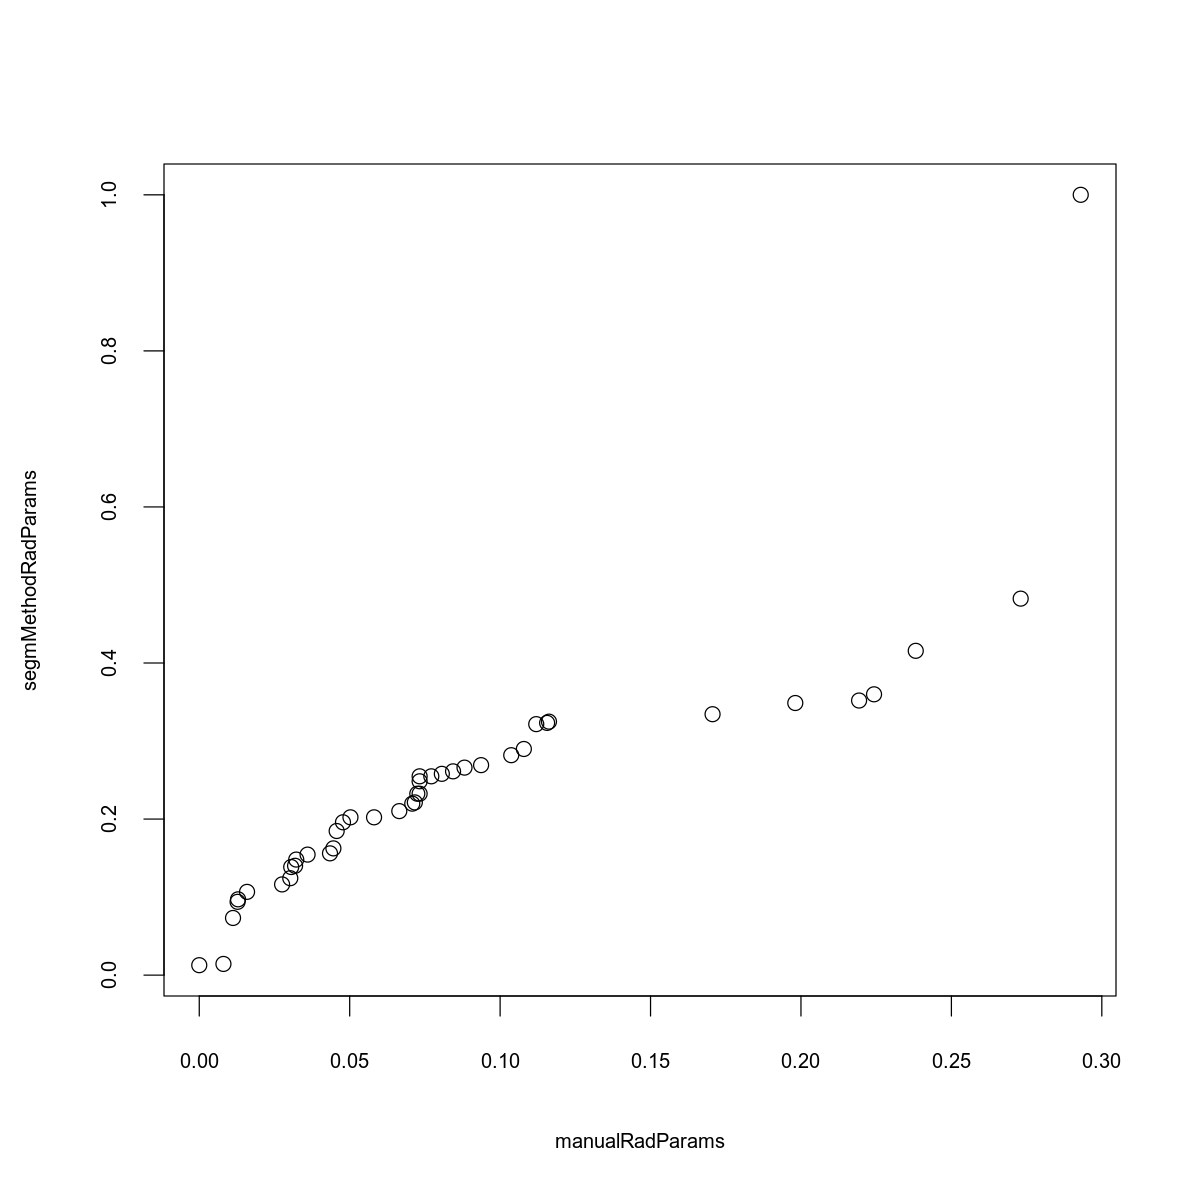

In [18]:
#csak probalkozas
#vajon mennyire normalisak a  legutolso radparamhoz tartozo  man es a legutolso segm modszerhez tartozo p ertekek?
cat("segmMethodName: ",segmMethodName,", from: ",segmMethodNames)
cat("\n\n")

hist(manualRadParams,breaks=50)
hist(segmMethodRadParams,breaks=50)
qqplot(manualRadParams,segmMethodRadParams)


In [34]:
# #vesszuk a negativ logaritmusat a Fisher p ertkekenek rad. par. csoportonkent

#Kivesszuk az UT algoritmust, mert nehezen magyarazhato, hogy miert hasonlit kevesbe a manualis maszkhoz mint azok amikbol szamolva lett (RG+FCM). 
#Valoszinuleg szamolasi hiba van az UT szamolasakor. A ket hasonlosagi parameter (-log fisher-p-value) koze, jobb esetben ala keleltt volna skalazodnia.
fm=fm[,1:11]

if(calc_fisherM_of_pvalues==T)
{
    print("calc_fisherM_of_pvalues")
    
    dn=paste0("./figurak/",prefix,"_bw_",bw,"_hmap_and_barplot_of_minusLogFisherPValues_of_man_and_algi_vs_radParamGroups/")
    dir.create(dn)
    fn=paste0("excluded_tmp_","_")   # excluded = ki van zarva egy par first order parameter
    png(file=paste0(dn,fn,".png"),width=1000,height=1000)
    #fun_calc_fisherM_of_pvalues(prefix,bw,radiomicsGroupNames,segmMethodNames,fm)
    corrplot( -log10(as.matrix(fm)), is.corr=F, tl.cex = 2,cl.cex=1.3)
    dev.off()

    cairo_ps(file=paste0(dn,fn,".eps")) #,width=1000,height=1000
    corrplot( -log10(as.matrix(fm)), is.corr=F, tl.cex = 1, cl.cex=.75)
    dev.off()    
    
    fn=paste0("excluded_tmp_hmap_","_")   # excluded = ki van zarva egy par first order parameter
    png(file=paste0(dn,fn,".png"),width=1000,height=1000)
    p2=heatmap(-log10(fm),scale="none",Rowv=NA, Colv=NA)
    dev.off() 
}
#radGroupNames: 'firstorder''glcm''shape''glszm''glrlm''ngtdm''gldm'
#segmMethodNames: 'fcm''gmm''km''ac''rg''rw''maj_6_3''maj_6_4''maj_6_5''maj_6_6''ut'

[1] "calc_fisherM_of_pvalues"


Warning message in dir.create(dn):
“'./figurak/queried_CSVs/_bw__hmap_and_barplot_of_minusLogFisherPValues_of_man_and_algi_vs_radParamGroups' already exists”


png 
  2

In [20]:
###########################################################################################################
#alg-onkent osszeadom a rad.param.group-okhoz tartozo p-value-kat, igy jobban osszehasonlithatoak az alg-ok
if(calc_sum_of_fisherM_of_pvalues==T)
{
    print("calc_sum_of_fisherM_of_pvalues")
    fun_calc_sum_of_fisherM_of_pvalues(prefix,bw,segmMethodNames,radiomicsGroupNames,fm)
}

In [21]:
###########################################################################################################################
#szuper fisher modszer = a fisher modszerrel osszekombinalt p-value-kat ujra fisher modszerrel osszekombinalom, majd -log()
if(calc_super_fisherM_of_pvalues==T)
{
    print("calc_super_fisherM_of_pvalues")
    fun_calc_super_fisherM_of_pvalues(prefix,bw,fm,segmMethodNames)
}



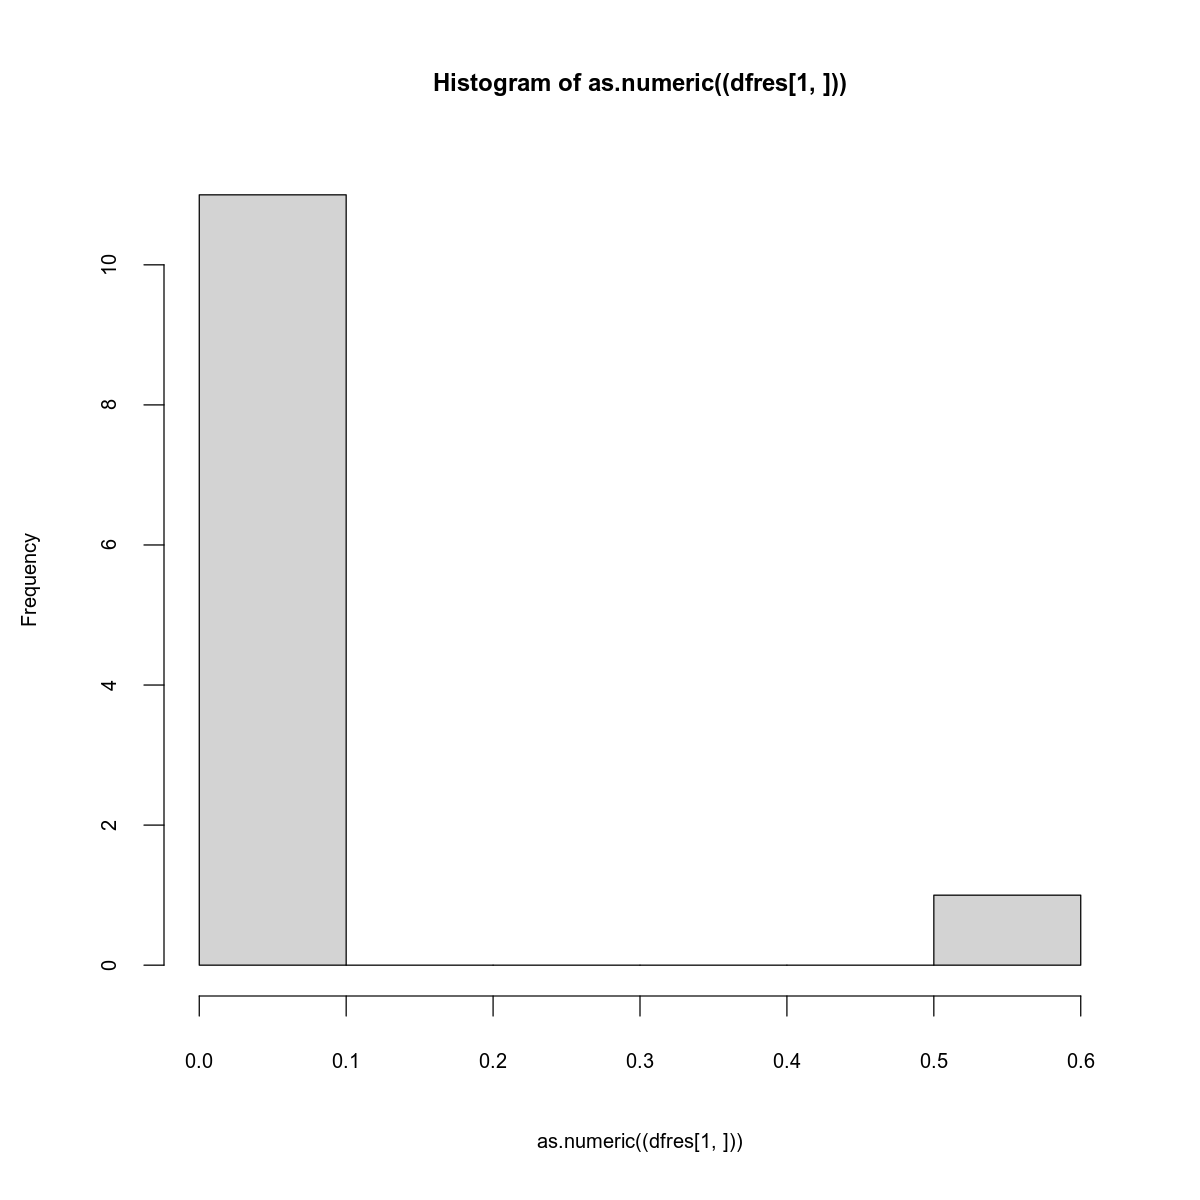

In [22]:
### Annak vizsgalta, hogy az egyes rad parametercsoportokban a parametereket leiro korrelacios matrix sorai mennyire kovetik a normalis eloszlast
#itt a gldm rad param csoportot nezem az osszes alg fgv-ben
#csak ranezesre vizsgalom, mennyire gauss alaku a histogram. Ez kell ahhoz, hogy az mvconv-ot lehessen hasznalni! Ld. lentebb ebben a cellaban
#length(as.numeric((dfres[1,])))
hist(as.numeric((dfres[1,])))  #12 oszlopa van a dfresnek=ahany alg. Rad.param. csoportonkent elter szamu parameter, pl gldm-nel 14

#Ez nagyon normalis eloszlasu!!! irodalmi adat
#hist(as.numeric(grid2ip.ld[1,]))

#ez az idezet innen van: https://cran.r-project.org/web/packages/poolr/poolr.pdf
# use mvnconv() to convert the LD correlation matrix into a matrix with the
# correlations among the (two-sided) p-values assuming that the test
# statistics follow a multivariate normal distribution with correlation
# matrix r (note: 'side = 2' by default in mvnconv())

In [23]:
segmMethodNames
radiomicsGroupNames

[1] "AC"        "FCM"       "GMM"       "KM"        "MAJ_6_3"   "MAJ_6_4"  
 [7] "MAJ_6_5"   "MAJ_6_6"   "nnunet531" "RG"        "RW"        "UT"

[1] "firstorder" "glcm"       "shape"      "glszm"      "glrlm"     
[6] "ngtdm"      "gldm"

In [24]:
#replaces p-values with NA if the distribution behind p-value is not normal
tmp1=0
for (p in 4:ncol(df))
{   #df columns: parameters, lines algorithms, first 3 columns are administrative ones
    c=0
    for (s in segmMethodNames)
    {  #manual is not examined here, that is the last column is ignored
        if (goodOrnot[p-3,s]==1) #row: params, col: algs
        {
            c=c+1
        }
    }
    if(c==12) #all of goodOrnot matrix is +1 (that is normal), ezek maradnak meg a fisher modszerhez, mert ezek normalis eloszlasuak
    {
        print(rownames(goodOrnot)[p-3])   #ha ebben a rad parameter eseteben minden segm alg normalis, akkor azokat osszegyujtom a tmp1-bes
        tmp1=rbind(tmp1,dfresAll[p-3,])
    }
}
tmp1=tmp1[-1,]  #first line is unnecessary and annoying

[1] "firstorder_90percentile"
[1] "firstorder_maximum"
[1] "firstorder_rootmeansquared"
[1] "glcm_jointaverage"
[1] "glcm_sumaverage"
[1] "gldm_dependenceentropy"
[1] "glrlm_graylevelvariance"
[1] "glrlm_runentropy"


In [25]:
tmp1
radiomicsGroupName

,AC,FCM,GMM,KM,MAJ_6_3,MAJ_6_4,MAJ_6_5,MAJ_6_6,nnunet531,RG,RW,UT
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
firstorder_90percentile,1.200274e-01,0.1373948259,1.083696e-02,0.1591814820,0.1396955515,9.725641e-02,3.738678e-02,8.923091e-03,0.4514222,0.6194515891,4.602704e-02,0.1086806530
firstorder_maximum,8.764309e-01,0.9105847217,9.586632e-01,0.9105847217,0.9105847217,9.105847e-01,9.140098e-01,9.194700e-01,0.7415288,0.8363204178,9.105847e-01,0.8431946329
firstorder_rootmeansquared,1.525564e-03,0.0030516329,1.061392e-06,0.0043690713,0.0028044281,6.879472e-04,5.297181e-05,5.562131e-07,0.2166856,0.2586876090,8.500538e-05,0.0014409093
glcm_jointaverage,9.311724e-01,0.0608990937,4.168620e-01,0.1139764761,0.0597187524,1.100778e-01,6.687544e-03,3.446995e-01,0.9098696,0.1772581985,4.568713e-05,0.0736568842
glcm_sumaverage,9.311724e-01,0.0608990937,4.168620e-01,0.1139764761,0.0597187524,1.100778e-01,6.687544e-03,3.447019e-01,0.9098696,0.1772581985,4.568713e-05,0.0736568842
shape_elongation,1.834864e-01,0.4268442937,2.151921e-01,0.3783278095,0.2920142978,4.654945e-01,7.103440e-01,1.635609e-01,0.7120232,0.3184489070,8.022218e-01,0.4957354337
glszm_graylevelvariance,2.307561e-06,0.0006060640,6.672792e-13,0.0004538386,0.0008834179,2.030690e-06,6.991411e-09,1.267390e-12,0.4281152,0.0001839408,1.525889e-09,0.0001598474
glszm_sizezonenonuniformity,1.577380e-02,0.0005506407,7.678336e-06,0.0025756416,0.0008302254,1.095360e-03,1.665630e-05,1.497368e-05,0.1743175,0.8397830478,4.829193e-05,0.0005337393


[1] "gldm"

In [28]:
#ez a lenyeg ez adja meg a legutolso grafikont
source('015_funcs.r')

#Kivesszuk az UT algoritmust, mert nehezen magyarazhato, hogy miert hasonlit kevesbe a manualis maszkhoz mint azok amikbol szamolva lett (RG+FCM). 
#Valoszinuleg szamolasi hiba van az UT szamolasakor. A ket hasonlosagi parameter (-log fisher-p-value) koze, jobb esetben ala keleltt volna skalazodnia.
tmp1$UT=NULL

# #vesszuk a negativ logaritmusat a Fisher p ertkekenek, de nem csoportonkent, mint a korabbi fisher-es szamolasban
if(calc2_fisherM_of_pvalues==T)
{
    print("calc2_fisherM_of_pvalues")
    fun_calc2_fisherM_of_pvalues(segmMethodNames,tmp2)   #,radiomicsGroupName,radiomicsGroupNames
#    fun_calc2_fisherM_of_pvalues(segmMethodNames,dfresAll,radiomicsGroupName,radiomicsGroupNames)
}

[1] "calc2_fisherM_of_pvalues"


Warning message:
“Matrix 'R' is not positive definite. Used Matrix::nearPD() to make 'R' positive definite.”
Warning message:
“Matrix 'R' is not positive definite. Used Matrix::nearPD() to make 'R' positive definite.”
Warning message:
“Matrix 'R' is not positive definite. Used Matrix::nearPD() to make 'R' positive definite.”
Warning message:
“Matrix 'R' is not positive definite. Used Matrix::nearPD() to make 'R' positive definite.”
Warning message:
“Matrix 'R' is not positive definite. Used Matrix::nearPD() to make 'R' positive definite.”
Warning message:
“Matrix 'R' is not positive definite. Used Matrix::nearPD() to make 'R' positive definite.”
Warning message:
“Matrix 'R' is not positive definite. Used Matrix::nearPD() to make 'R' positive definite.”
Warning message:
“Matrix 'R' is not positive definite. Used Matrix::nearPD() to make 'R' positive definite.”
Warning message:
“Matrix 'R' is not positive definite. Used Matrix::nearPD() to make 'R' positive definite.”
Warning message:
“M

[1] 43.05068

[1] 1
attr(,"df")
[1] 202

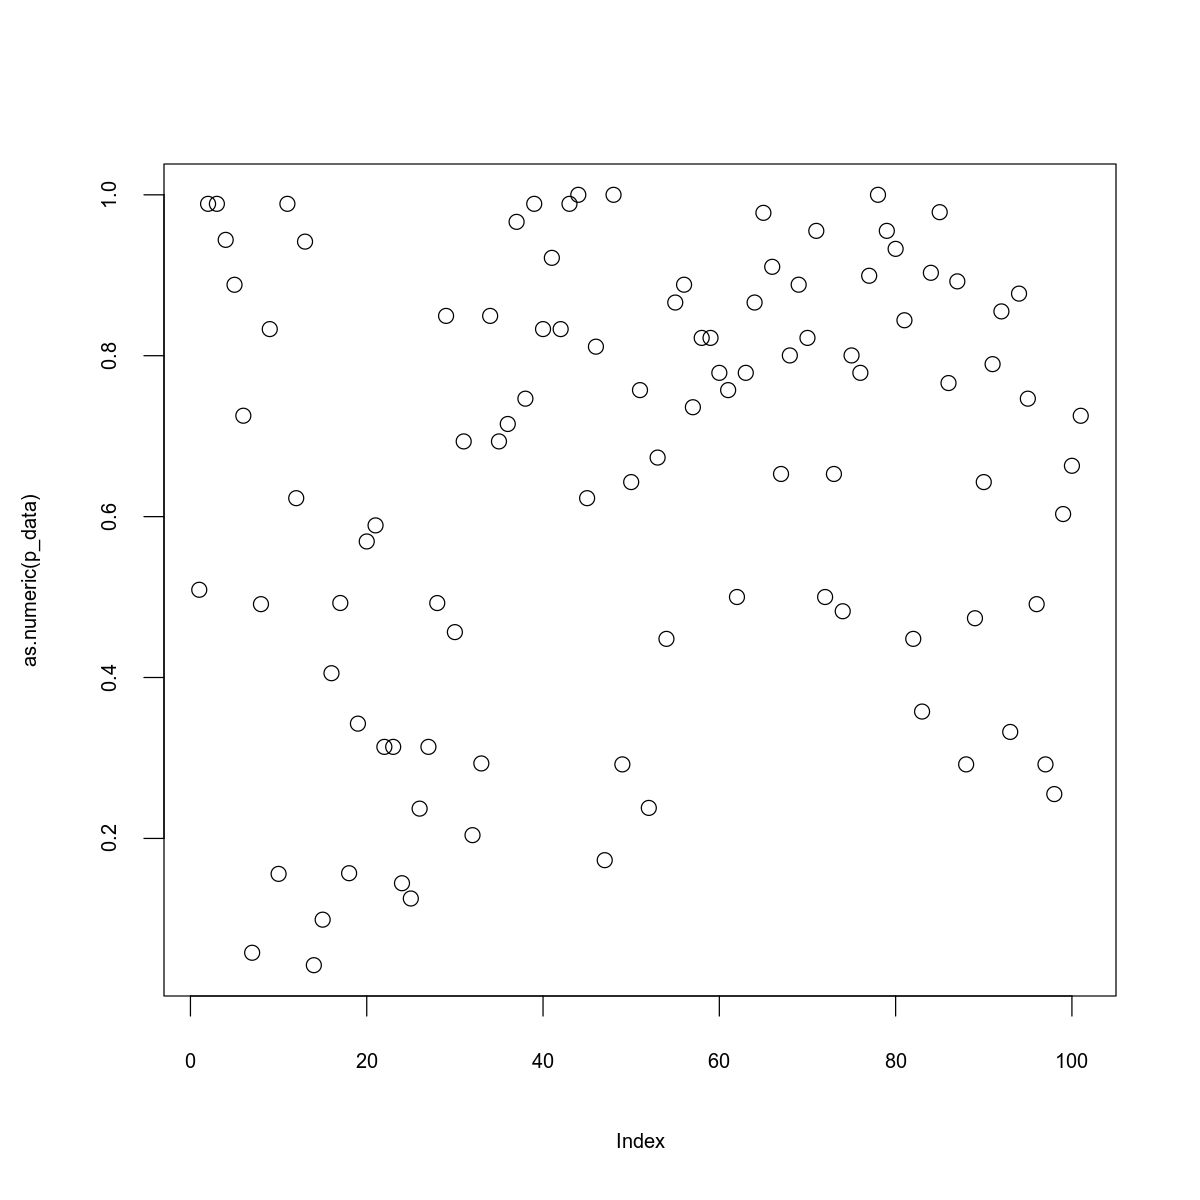

In [36]:
#mennyire normal vagy nem normal eloszlasu egy algoritmushoz tartozo rad. params. Semennyire
p_data=dfresAll[,1]
plot(as.numeric(p_data))
stat=-2*sum(p_data*log(p_data))
stat
attr(stat,"df")=2*length(p_data)
pchisq(stat, df = attr(stat,"df"), lower.tail = FALSE)

[1] "----"
[1] 43.05068
[1] "----"
[1] 48.13826
[1] "----"
[1] 46.46038
[1] "----"
[1] 45.88423
[1] "----"
[1] 43.82839
[1] "----"
[1] 46.43834
[1] "----"
[1] 43.05025
[1] "----"
[1] 43.80438
[1] "----"
[1] 45.52964
[1] "----"
[1] 51.26155
[1] "----"
[1] 48.09788
[1] "----"
[1] 42.3608


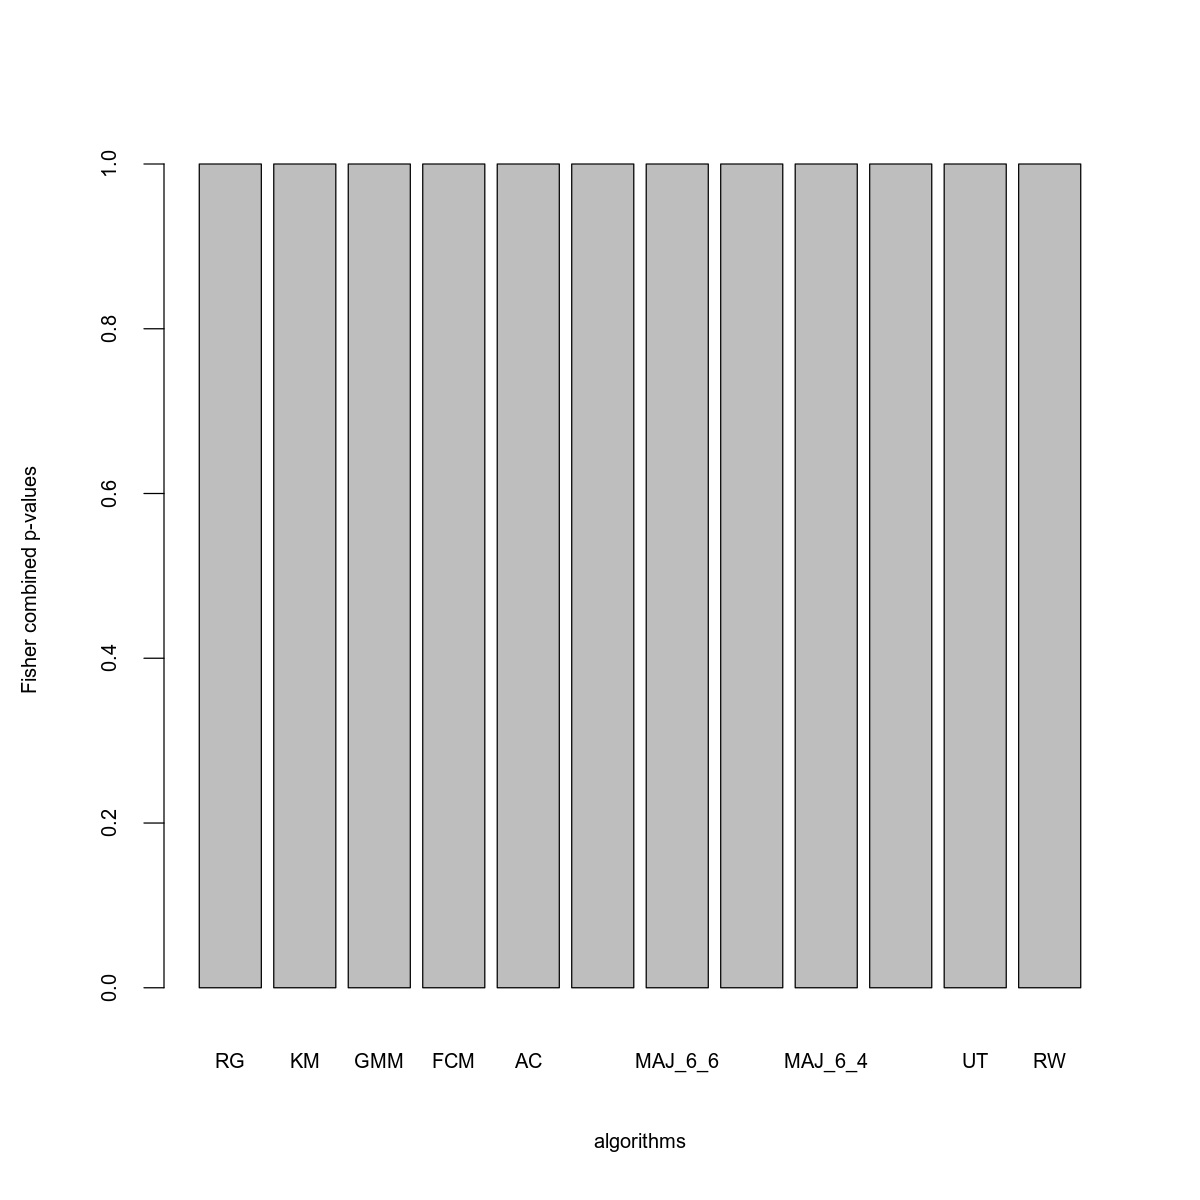

In [37]:
#megprobaltam a shannon fele informaciotartalmat becsempeszni a stat analizisbe, nem sikerult. De van egy ilyen szeru szamolt 
#parameter a pyradiomics parameterek kozott is.
#source("015_funcs.r")
fisherMM <- function(p_data){
    #data = -log10( apply(dfresAll,2,fisherM) )  
    #^2 = -2 sum_{i=1}^k ln(p_i)
    #fisher(data)$p
#    S=0
#    for(i in seq(1,length(data)))
#    {
#        #print(paste0("i: ",i,", ",data[i]))
#        S=S-2*log(data[i])    # X^2 = -2 sum_{i=1}^k ln(p_i). 
#    }
#    return(S)
    statistic=-2*sum(p_data*log(p_data))   #ez pont ugyanaz mint a student-t nel a proba fgv. amibol a p erteket kell meghatarozni
    k <- length(p_data)                    #ez a szabadsagi fokok szama
    print("----")
    print(statistic)
    #print(head(p_data*log(p_data)))
    attr(statistic, "df") <- 2 * k
    #distribution function of for chi squared distribution (chi^2)
    pval <- pchisq(statistic, df = 2 * k, lower.tail = FALSE)       #maga a proba statisztikahoz rendelt p-value. A lower.tail=FALSE azt jelenti, hogy mi annak a valsege, hogy a valsegi valtozo a proba
                                                                    #statisztikanal nagyobb erteket vesz fel == a proba stat.-tol jobbra eso gorbe alatti terulet erdekel. 
                                                                    #Uaz mintha 1-bol vonnam ki a default (lower.tail=TRUE-nak megfelelo) erteket
    #res <- list(p = c(pval), ci = NULL, k = k, m = NULL, adjust = "none", 
    #    statistic = statistic, size = NULL, fun = as.character(sys.call()[1]))
    #return(res)
    #print(pval)
    return(pval)
}

data = (apply(dfresAll,2,fisherMM))                  #apply() masodik parametere = 2, mert a dfresAll oszlopaibol(=alg-ok, osszesen 11db) csinal vektort es arra alkalmazza

barplot(data,names.arg=names(data),xlab="algorithms",ylab="Fisher combined p-values")

# #vesszuk a negativ logaritmusat a Fisher p ertkekenek, de nem csoportonkent, mint a korabbi fisher-es szamolasban
#if(calc2_fisherM_of_pvalues==T)
#{
#    fun_calc3_fisherM_of_pvalues(dfresAll)
#}